In [1]:
import numpy as np
import math
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import get_cmap
cmap = get_cmap('seismic_r')
norm = Normalize(vmin=0.001, vmax=0.1)

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 8]

/tmp/ipykernel_3741137/2456782813.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('seismic_r')


# Data Exploration

In [2]:
data_dir = '/n/data2/hms/dbmi/sunyaev/lab/sgandhi/effect_size/variant datasets/Beltran'
ddG_df = pd.read_csv(f'{data_dir}/SupplementaryTable4.txt', sep='\t')
VEP_df = pd.read_csv(f'{data_dir}/SupplementaryTable5.txt', sep='\t')

In [3]:
# What we're going to now do is turn each of these variants into genomic coordinates and allele changes
# Start with ddG_df
ddG_df

,PFAM_entry,uniprot_ID,gene_ID,pos,wt_aa,mut_aa,mean_kcalmol_scaled,std_kcalmol_scaled
0,BICC1_HUMAN/286-350,Q9H694,BICC1,305,S,A,-0.178952,0.059597
1,BICC1_HUMAN/286-350,Q9H694,BICC1,305,S,C,-0.182304,0.051186
2,BICC1_HUMAN/286-350,Q9H694,BICC1,305,S,D,-0.209050,0.052898
3,BICC1_HUMAN/286-350,Q9H694,BICC1,305,S,E,-0.346066,0.108385
4,BICC1_HUMAN/286-350,Q9H694,BICC1,305,S,F,-0.127790,0.043919
...,...,...,...,...,...,...,...,...
4107431,STAC2_HUMAN/299-347,Q6ZMT1,STAC2,315,P,S,-0.085844,0.055535
4107432,STAC2_HUMAN/299-347,Q6ZMT1,STAC2,315,P,T,-0.107582,0.064323
4107433,STAC2_HUMAN/299-347,Q6ZMT1,STAC2,315,P,V,-0.112647,0.075831
4107434,STAC2_HUMAN/299-347,Q6ZMT1,STAC2,315,P,W,0.283795,0.160154


In [6]:
import requests

def uniprotToGene(uniprot_id):
    # UniProt REST API URL (UniProtKB API returns JSON)
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        # The gene name is usually under 'genes'
        if 'genes' in data:
            gene_names = []
            for gene in data['genes']:
                if 'geneName' in gene and 'value' in gene['geneName']:
                    return gene['geneName']['value']
        else:
            print(f"No gene names found for {uniprot_id}")
            return None
    else:
        print(f"Error: {response.status_code} - {response.reason}")
        return None

def returnENSP(gene):
    url = f'https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene}?expand=1'
    headers = {'Content-type': 'application/json'}
    
    response = requests.get(url, headers=headers)
    
    if response.ok:
        data = response.json()
    else:
        print(f"Error: {response.status_code} - {response.reason}")
        return None

    try:
        ensp = data['Transcript'][0]['Translation']['id']
        return ensp
    except:
        return None

def enspToCoordinates(ensp, pos):
    url = f'https://rest.ensembl.org/map/translation/{ensp}/{pos}..{pos+1}?'
    headers = {'Content-type': 'application/json'}
    
    response = requests.get(url, headers=headers)
    
    if response.ok:
        data = response.json()
    else:
        print(f"Error: {response.status_code} - {response.reason}")

    chrom = data['mappings'][0]['seq_region_name']
    start = data['mappings'][0]['start']
    end = data['mappings'][0]['end']

    return chrom, start, end

def mapCDS(gene):
    gene_id = get_ensembl_gene_id(gene)
    cds = get_longest_cds(gene_id)
    ens_id = cds[0]
 
    server = "https://rest.ensembl.org"
    ext = f"/map/cds/{ens_id}/1..{len(cds[1])}?"
     
    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
     
    if not r.ok:
      return None
     
    decoded = r.json()

    # Sort the contigs based on start
    contigs = pd.DataFrame(0, index=[], columns=['start', 'end', 'strand'])
    for i, contig in enumerate(decoded['mappings']):
        strand = 0
        if contig['strand'] != 0:
            contigs.loc[len(contigs), :] = [contig['start'], contig['end'], contig['strand']]
            strand = contig['strand']
    contigs = contigs.sort_values(by='start')
    
    # Next, we go through and give each nucleotide its correct position
    mapped_positions = []
    for i in range(len(contigs)):
        mapped_positions.extend(np.arange(contigs.loc[i, 'start'], contigs.loc[i, 'end'] + 1))
    
    mapped_positions = [int(x) for x in mapped_positions]
    return mapped_positions, strand


def get_ensembl_gene_id(gene_name):
    # Define the Ensembl REST API URL for gene search
    base_url = "https://rest.ensembl.org"
    endpoint = f"/lookup/symbol/human/{gene_name}?content-type=application/json"
    
    # Send the request to the Ensembl API
    response = requests.get(base_url + endpoint)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response to get the Ensembl Gene ID (ENSG)
        data = response.json()
        
        # Return the ENSG gene ID if found
        ensembl_gene_id = data.get('id', None)
        if ensembl_gene_id:
            return ensembl_gene_id
        else:
            return "Gene not found"
    else:
        return f"Error: {response.status_code}"

In [51]:
import sys

sys.path.append("/home/sjg319/monosemanticity/bio_models_sae/utils")

from utils.toga_utils import *

In [53]:
from utils.msa_helpers import *

In [12]:
with open("runscripts/uniprot_pos.pkl", "rb") as f:
    uniprot_pos = pickle.load(f)

# uniprot_pos = list(set(uniprot_pos)).sort()

chunk_id = 1
num_chunks = 20

chunked = np.array_split(uniprot_pos, num_chunks)
my_chunk = chunked[chunk_id]

In [47]:
mapCDS(gene)

NameError: name 'get_longest_cds' is not defined

In [55]:
genomic_coords = pd.DataFrame('', index=np.arange(len(my_chunk)), columns=['chr', 'start', 'end', 'gene', 'ref', 'seq', 'strand'])

gene_data = {}
chr_data = {}
uniprot_to_gene = {}
gene_to_ens = {}
skipped = []

for i in tqdm(np.arange(len(my_chunk))[0:10]):
    uniprot_id, pos = my_chunk[i]
    pos = int(pos)
    try:
        subset = ddG_df[(ddG_df['uniprot_ID'] == uniprot_id) & (ddG_df['pos'] == pos)]
        ref_aa = subset['wt_aa'].iloc[0]

        # Map uniprot -> gene
        if uniprot_id not in uniprot_to_gene:
            url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
            response = requests.get(url)
            data = response.json()
            gene = data["genes"][0]["geneName"]["value"]
            uniprot_to_gene[uniprot_id] = gene
        else:
            gene = uniprot_to_gene[uniprot_id]

        # Map gene -> transcript
        if gene not in gene_to_ens:
            url = f"https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene}?expand=1"
            headers = {"Content-Type": "application/json"}
            response = requests.get(url, headers=headers)
            data = response.json()
            ens_id = data['Transcript'][0]['id']
            gene_to_ens[gene] = ens_id
        else:
            ens_id = gene_to_ens[gene]

        # Get CDS mapping
        if gene not in gene_data:
            mapped_pos, strand = mapCDS(gene)
            mapped_pos = np.sort(mapped_pos)
            gene_data[gene] = (mapped_pos, strand)
        else:
            mapped_pos, strand = gene_data[gene]
            mapped_pos = np.sort(mapped_pos)

        if strand == -1:
            mapped_pos = mapped_pos[::-1]
            dna_pos = (pos-1)*3
            end = mapped_pos[dna_pos]
            start = mapped_pos[dna_pos+2]
        else:
            dna_pos = (pos-1)*3
            start = mapped_pos[dna_pos]
            end = mapped_pos[dna_pos+2]

        print(start, end)

        # Get chromosome
        if gene in chr_data:
            chrom = chr_data[gene]
        else:
            url = f"https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene}?content-type=application/json"
            response = requests.get(url)
            data = response.json()
            chrom = data['seq_region_name']
            chr_data[gene] = chrom

        # Get DNA sequence
        url = f"https://rest.ensembl.org/sequence/region/human/{chrom}:{start}..{end}:{strand}"
        headers = {"Content-Type": "text/plain"}
        response = requests.get(url, headers=headers)
        if response.ok:
            seq = response.text.strip()
        else:
            seq = ''

        genomic_coords.iloc[i, :] = [chrom, start, end, gene, ref_aa, seq, strand]

    except Exception as e:
        skipped.append(i)

  0%|          | 0/10 [00:00<?, ?it/s]

111334701 111334703


 10%|█         | 1/10 [00:04<00:43,  4.83s/it]

12 111334701 111334703 CUX2 N AAC 1
111334704 111334706


 20%|██        | 2/10 [00:05<00:18,  2.33s/it]

12 111334704 111334706 CUX2 N AAT 1
111334707 111334709


 30%|███       | 3/10 [00:05<00:10,  1.52s/it]

12 111334707 111334709 CUX2 L CTA 1
111334710 111338287


 40%|████      | 4/10 [00:06<00:06,  1.14s/it]

12 111334710 111338287 CUX2 G GGTACGGAGCGGGTGGGAATCGGAGAGGCTGCCTCCCACCTGGGTTGGCTCCTACTTGCCTTGAAAAGGTGTCTGGAGCTGGGACCCAGTGGCTCATACCTGTAATTCCAGTGCTTTGGGAGGCCAGGGAGGGAGGATCGCTTGAGGCCAGGAGTTTGAGGCCAACCTGGGCAGCATAGCAAGATCTCATATCTTAAAAAAGCTTTTTAAAATTAGCTGAAAACTCCATGCATACAAACTTCACACGTGTTGGTGCATGCCTGTAGTCCTAGCAACTCAGGAGCCTGAGGCAGGAGAATCGCGTGAGCCCAGGAGTTCAAGGCTGCAGTGAGCTATGATCATGCCACTGCATGCCAGCCTGGGCAACAGAGCAAGACCTTGTCTATAAAATAAATTAATGGCTGTGCATGGTGGCTCACACCTGTAATCCCAGCATTTTGGGAGGCCCAGGCAGGTGGATCATCTGAGGTCAGCAGTTCGAGACCAGCCTGGCCAACATGGTGAAACCTCGTCTCTACTAAAAATACAAAAAAATTAACCAGGCGTGGTGGCACATGCCTGTAGTCCCAGCTACTTGGGAGGCTGAGGCAGGAGAATCGCTTGAACCTGGGAGGCAGAGGTTGCAGTGAGCCGAGATCACACCACTGCACTCTAGCCAAGGCGACAGAGCGAGACCTCATCTCAAAAAAAAAATCAGTCAATCAGTAAAATAAAAAACAAGCTGGGCCCGGTGCCTCACGCCTGTAACCTCAGCACTTTGGGAGGCCAAGGCAGGCGAATCACCTCAGGTCAGGAGTTCCAGATCAGCCTGGCCAACATGGTGAAACCCCATCTCTACTAAAAATACAAAAAGTAGCCGGGTGTGGTGGCATGCACTTGGAATCCCAGCAACTCAGGAGGCTGAGGAGAATCGTTTGAATCCAGGAGGTGGAGGTTGCAGTGAGCCGAGATTGTACCACTGCACTCCAGC

 50%|█████     | 5/10 [00:07<00:04,  1.07it/s]

12 111338288 111338290 CUX2 Q CAG 1
111338291 111338293


 60%|██████    | 6/10 [00:07<00:03,  1.25it/s]

12 111338291 111338293 CUX2 R CGG 1
111338294 111338296


 70%|███████   | 7/10 [00:08<00:02,  1.39it/s]

12 111338294 111338296 CUX2 L CTG 1
111338297 111338299


 80%|████████  | 8/10 [00:08<00:01,  1.40it/s]

12 111338297 111338299 CUX2 F TTT 1
111338300 111338302


 90%|█████████ | 9/10 [00:09<00:00,  1.50it/s]

12 111338300 111338302 CUX2 G GGG 1
111338303 111338305


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

12 111338303 111338305 CUX2 E GAA 1


In [58]:
genomic_coords[0:20]

,chr,start,end,gene,ref,seq,strand
0,12,111334701,111334703,CUX2,N,AAC,1
1,12,111334704,111334706,CUX2,N,AAT,1
2,12,111334707,111334709,CUX2,L,CTA,1
3,12,111334710,111338287,CUX2,G,GGTACGGAGCGGGTGGGAATCGGAGAGGCTGCCTCCCACCTGGGTT...,1
4,12,111338288,111338290,CUX2,Q,CAG,1
5,12,111338291,111338293,CUX2,R,CGG,1
6,12,111338294,111338296,CUX2,L,CTG,1
7,12,111338297,111338299,CUX2,F,TTT,1
8,12,111338300,111338302,CUX2,G,GGG,1
9,12,111338303,111338305,CUX2,E,GAA,1


In [9]:
genomic_coords = pd.DataFrame('', index=np.arange(len(uniprot_pos)), columns=['chr', 'start', 'end', 'gene', 'ref', 'seq', 'strand'])

gene_data = {}
chr_data = {}
uniprot_to_gene = {}
gene_to_ens = {}
skipped = []
for i in tqdm(np.arange(len(uniprot_pos))):
    uniprot_id, pos = uniprot_pos[i]
    try:
        subset = ddG_df[ddG_df['uniprot_ID'] == uniprot_id]
        subset = subset[subset['pos'] == pos]
        ref_aa = subset['wt_aa'].iloc[0]

        ## First, we get the unprot id and turn that into the appropriate gene
        if uniprot_id not in uniprot_to_gene.keys():
            url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
            response = requests.get(url)
            data = response.json()
            gene = data["genes"][0]["geneName"]["value"]
            uniprot_to_gene[uniprot_id] = gene
        else:
            gene = uniprot_to_gene[uniprot_id]

        ## Next, we turn the gene into an ens id
        if gene not in gene_to_ens.keys():
            species = "homo_sapiens"
    
            url = f"https://rest.ensembl.org/lookup/symbol/{species}/{gene}?expand=1"
            headers = {"Content-Type": "application/json"}
            
            response = requests.get(url, headers=headers)
            data = response.json()
            ens_id = data['Transcript'][0]['id']
            gene_to_ens[gene] = ens_id
        else:
            ens_id = gene_to_ens[gene]
    
        ## Get the start and end position
        if gene not in gene_data.keys():
            mapped_pos, strand = mapCDS(gene)
            mapped_pos = np.sort(mapped_pos)
            gene_data[gene] = (mapped_pos, strand)
        else:
            mapped_pos, strand = gene_data[gene]
            mapped_pos = np.sort(mapped_pos)
        
        if strand == -1:
            mapped_pos = mapped_pos[::-1]
            dna_pos = (pos-1)*3
            end = mapped_pos[dna_pos]
            start = mapped_pos[dna_pos+2]
        else:
            dna_pos = (pos-1)*3
            start = mapped_pos[dna_pos]
            end = mapped_pos[dna_pos+2]
    
        ## Get the chromosome
        if gene in chr_data.keys():
            chrom = chr_data[gene]
        else:
            species = "homo_sapiens"
            url = f"https://rest.ensembl.org/lookup/symbol/{species}/{gene}?content-type=application/json"
            response = requests.get(url)
            data = response.json()
            chrom = data['seq_region_name']
            chr_data[gene] = chrom

        ## Finally, get the sequence
        url = f"https://rest.ensembl.org/sequence/region/human/{chrom}:{start}..{end}:{strand}"
        headers = {"Content-Type": "text/plain"}
        response = requests.get(url, headers=headers)
        if response.ok:
            seq = response.text.strip()
        else:
            pass

        genomic_coords.iloc[i, :] = [chrom, start, end, gene, ref_aa, seq, strand]
        
    except:
        skipped.append(i)

 18%|█▊        | 9/50 [00:40<02:32,  3.71s/it]

No CDS sequences found for gene ENSG00000249459


 86%|████████▌ | 43/50 [03:41<00:28,  4.01s/it]

No CDS sequences found for gene ENSG00000281058


100%|██████████| 50/50 [04:16<00:00,  5.12s/it]


In [ ]:
genomicb

### Beltran et. al data analysis

In [18]:
data_path = '/n/data2/hms/dbmi/sunyaev/lab/sgandhi/effect_size/variant datasets/Beltran/processed_pairs'

chunk_dfs = [pd.read_csv(f'{data_path}/chunk_{x}.csv') for x in np.arange(0, 10)]
variant_dfs = pd.concat(chunk_dfs)
variant_dfs['start'] += 3
variant_dfs['end'] += 3

In [43]:
pairs = []
for i in range(len(variant_dfs)):
    pairs.append((variant_dfs['gene'].iloc[i], variant_dfs['start'].iloc[i]))

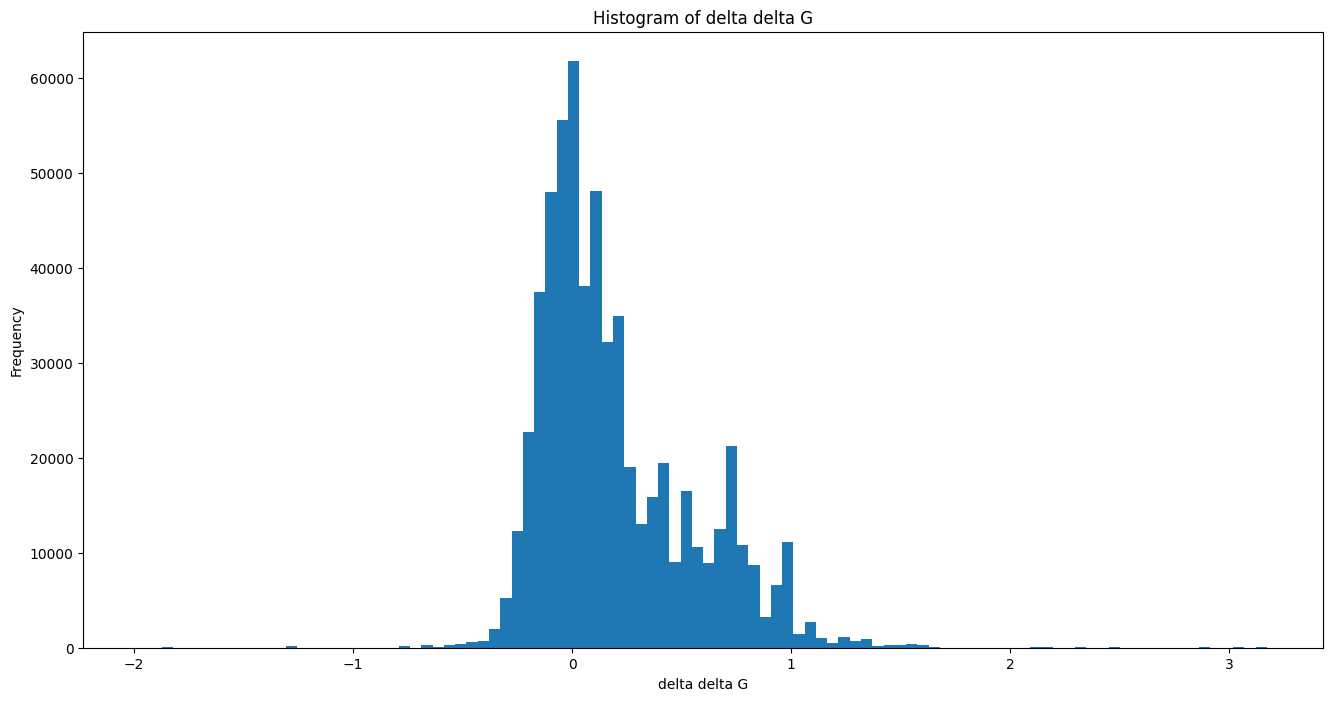

In [32]:
plt.hist(variant_dfs['mean kcolmol scaled'], bins=100)
plt.xlabel('delta delta G')
plt.ylabel('Frequency')
plt.title('Histogram of delta delta G')
plt.show()

0       -0.178952
1       -0.182304
2       -0.209050
3       -0.346066
4       -0.127790
           ...   
56024    0.054981
56025    0.217536
56026   -0.036841
56027   -0.090185
56028    0.218776
Name: mean kcolmol scaled, Length: 598648, dtype: float64

In [52]:
aa_list = list(set(variant_dfs['ref aa']))

# Note: index is the ref, column is the alt
ref_to_alt_df = pd.DataFrame(0.0, index=aa_list, columns=aa_list)
for aa1 in aa_list:
    for aa2 in aa_list:
        subset = variant_dfs[variant_dfs['ref aa'] == aa1]
        subset = subset[subset['alt aa'] ==  aa2]
        ref_to_alt_df.loc[aa1, aa2] = np.mean(subset['mean kcolmol scaled'])

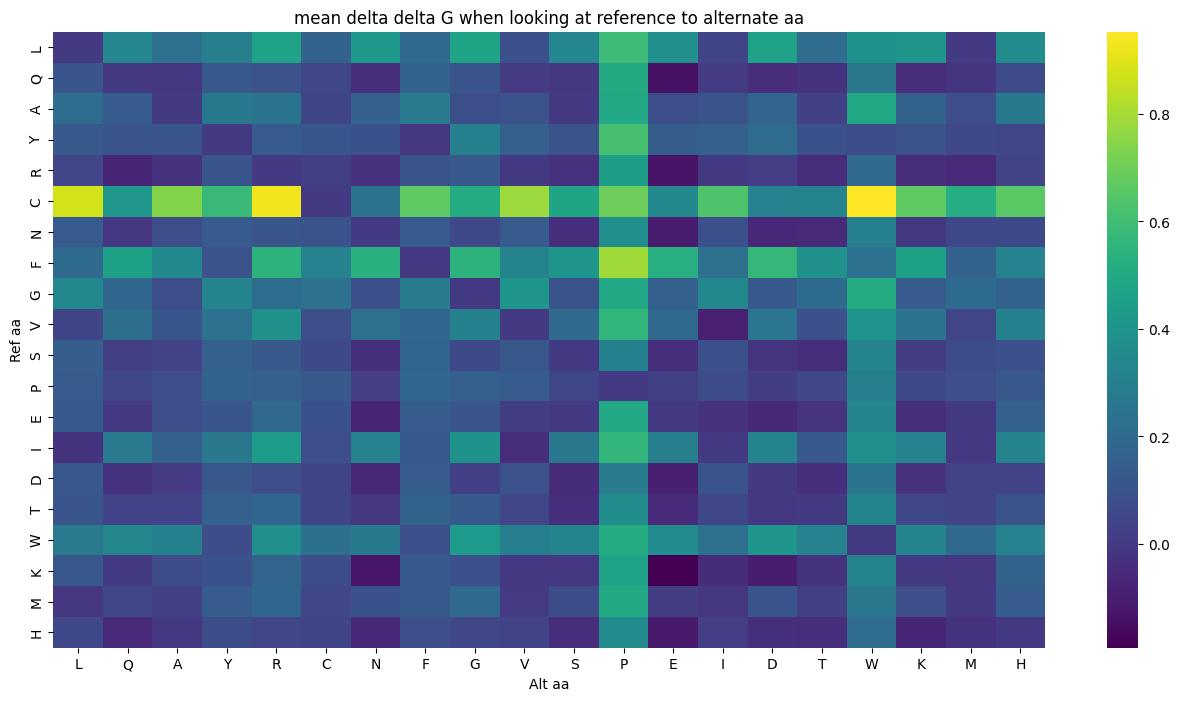

In [66]:
import seaborn as sns

ref_to_alt_df = ref_to_alt_df.fillna(0)
sns.heatmap(ref_to_alt_df, cmap='viridis')
plt.xlabel('Alt aa')
plt.ylabel('Ref aa')
plt.title('mean delta delta G when looking at reference to alternate aa')
plt.show()

In [71]:
genes = list(set(variant_dfs['gene']))
gene_counts = {}

for g in tqdm(genes):
    subset = variant_dfs[variant_dfs['gene'] == g]
    gene_counts[g] = len(set(subset['start']))

100%|██████████| 1002/1002 [00:29<00:00, 34.27it/s]


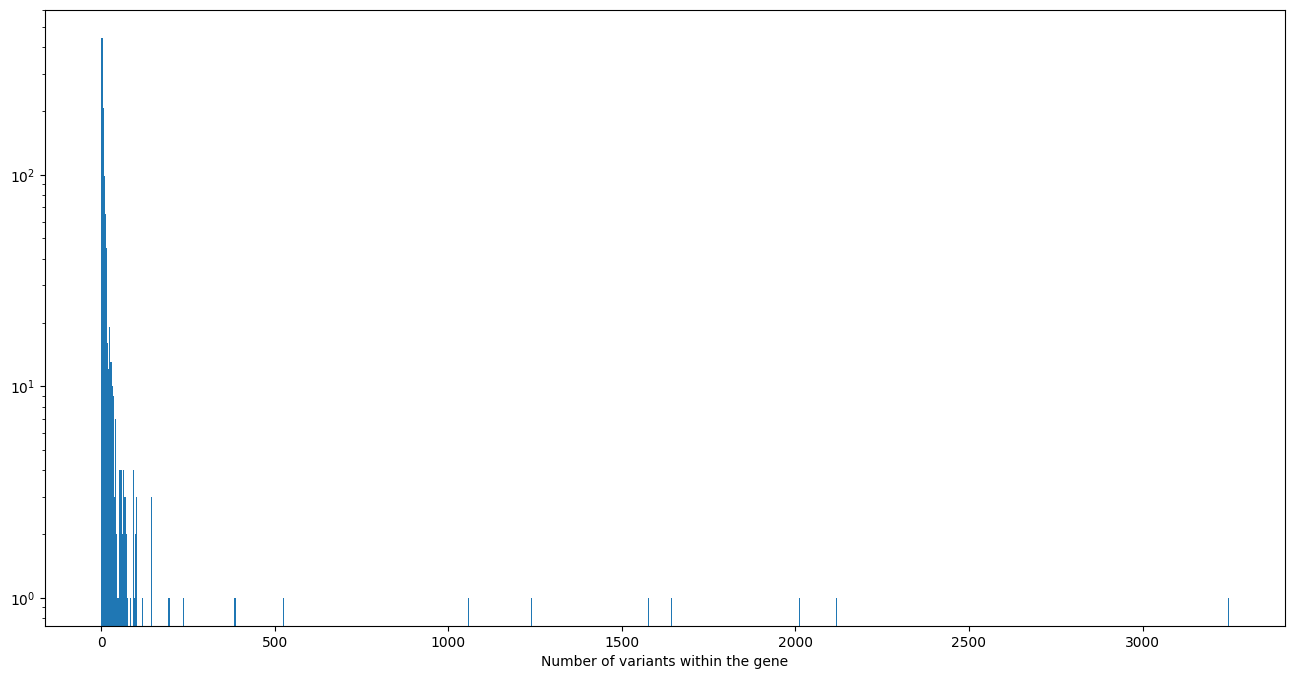

In [91]:
plt.hist(list(gene_counts.values()), bins=1000)
plt.yscale('log')
plt.xlabel('Number of variants within the gene')
plt.show()

In [99]:
np.sum([1 if x > 1 else 0 for x in list(gene_counts.values())])/len(gene_counts)

0.9590818363273453